# Model Construction

in this notebook, we will construct the model for the Goal-conditioned policy using a supervised learning approach. We will use the data collected from expert demonstrations to train the model. The model will be used to predict the next state given the current state and the goal state. The model will be used to generate the goal-conditioned policy.

This algorithm is inspired by the paper [Learning to Reach Goals via Iterated Supervised Learning](https://arxiv.org/abs/1912.06088) and the [GCSL code](https://github.com/dibyaghosh/gcsl)

In [12]:
# imports
import os
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.obs_utils as ObsUtils
import helper
import h5py
import numpy as np
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch
import bc_gcsl_model
import matplotlib.pyplot as plt


# change this to the path of the project
%cd /project
%load_ext autoreload
%autoreload 2

/project
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Project directory structure
ROOT_DIR = os.getcwd()
WS_DIR = os.path.join(ROOT_DIR, "src/")
DATA_DIR = os.path.join(ROOT_DIR, "data/")
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [3]:
## download the dataset
# user parameters
task_0 = "lift"
task_1 = "can"
task_2 = "square"
dataset_type = "ph"
hdf5_type = "low_dim"

# download the dataset
lift_data_path = helper.download_dataset(task_0, dataset_type, hdf5_type, DATA_DIR+task_0)
can_data_path = helper.download_dataset(task_1, dataset_type, hdf5_type, DATA_DIR+task_1)
square_data_path = helper.download_dataset(task_2, dataset_type, hdf5_type, DATA_DIR+task_2)

## Data loaders

In [4]:
# Aggregate the data from all the demonstrations/trajectories
# task_id = 0 for lift and task_id = 1 for can
lift_inputs, lift_actions = helper.aggregate_data(hdf5_path=lift_data_path, task_id=0)
can_inputs, can_actions = helper.aggregate_data(hdf5_path=can_data_path, task_id=1)
square_inputs, square_actions = helper.aggregate_data(hdf5_path=square_data_path, task_id=2)

# Create the datasets
dataset_lift = helper.CustomDataset(list(zip(lift_inputs, lift_actions)))
dataset_can = helper.CustomDataset(list(zip(can_inputs, can_actions)))
dataset_square = helper.CustomDataset(list(zip(square_inputs, square_actions)))

In [5]:
# Create the dataloaders
dataloader_lift = DataLoader(dataset_lift, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
dataloader_can = DataLoader(dataset_can, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
dataloader_square = DataLoader(dataset_square, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)

In [6]:
print(f"lift dataloader length: {len(dataloader_lift)} of batch size: {dataloader_lift.batch_size}")
for batch in dataloader_lift:
    inputs, actions = batch
    print(f"inputs shape: {inputs.shape}, actions shape: {actions.shape}")
    break

print(f"\ncan dataloader length: {len(dataloader_can)} of batch size: {dataloader_can.batch_size}")
for batch in dataloader_can:
    inputs, actions = batch
    print(f"inputs shape: {inputs.shape}, actions shape: {actions.shape}")
    break

print(f"\nsquare dataloader length: {len(dataloader_square)} of batch size: {dataloader_square.batch_size}")
for batch in dataloader_square:
    inputs, actions = batch
    print(f"inputs shape: {inputs.shape}, actions shape: {actions.shape}")
    break

lift dataloader length: 76 of batch size: 128
inputs shape: torch.Size([128, 39]), actions shape: torch.Size([128, 7])

can dataloader length: 182 of batch size: 128
inputs shape: torch.Size([128, 47]), actions shape: torch.Size([128, 7])

square dataloader length: 236 of batch size: 128
inputs shape: torch.Size([128, 47]), actions shape: torch.Size([128, 7])


## Model

In [7]:
# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
## Setting encoders size for the tasks
# task: lift
lift_input_dim = lift_inputs.shape[1] # 19 (state) + 19 (goal) + 1 (task identifier)
# task: can
can_input_dim = can_inputs.shape[1] # 23 (state) + 23 (goal) + 1 (task identifier)
# task: square
square_input_dim = square_inputs.shape[1] # 23 (state) + 23 (goal) + 1 (task identifier)
# setting the encoder
list_of_input_sizes = [lift_input_dim, can_input_dim, square_input_dim]
encoder = bc_gcsl_model.DynamicEncoder(list_of_input_sizes)

## Setting the model
action_dim = lift_actions.shape[1]
model = bc_gcsl_model.CustomBCModel(encoder, action_dim).to(device)

## Training

In [38]:
import time
import itertools


# Initialize model and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.MSELoss()

num_epochs = 100


# Create a list of indices for the DataLoaders and create an iterator that cycles through these indices
dataloaders = [dataloader_lift, dataloader_can, dataloader_square]
dataloader_indices = list(range(len(dataloaders)))
map_task_id_to_task_name = {0: "lift", 1: "can", 2: "square"}
dataloaders_cycle = itertools.cycle(dataloader_indices)

# Determine the maximum number of batches among the DataLoaders
max_batches = max(len(dataloader_lift), len(dataloader_can), len(dataloader_square))

# Initialize a list to store the last loss for each task
last_losses = [None] * len(dataloaders)
avg_loss_history = []
lift_loss_history = []
can_loss_history = []
square_loss_history = []

for epoch in range(num_epochs):
    epoch_start = time.time()

    data_loading_time = 0
    forward_pass_time = 0
    backward_pass_time = 0
     # Reset the iterator for each DataLoader at the start of each epoch
    dataloader_iters = [iter(loader) for loader in dataloaders]


    for batch_idx in range(max_batches * len(dataloaders)):
        # Get the next DataLoader index in the cycle
        current_dataloader_idx = next(dataloaders_cycle)
        # Get the next batch from the DataLoader
        current_dataloader_iter = dataloader_iters[current_dataloader_idx]

        try:
            inputs, actions = next(current_dataloader_iter)
        except StopIteration:
            # This DataLoader is exhausted, skip to the next one
            continue
        
        optimizer.zero_grad()

        start = time.time()
        # Forward pass

        predictions = model(inputs.to(device), current_dataloader_idx)
        forward_pass_time += time.time() - start

        start = time.time()
        # Backward pass
        loss = criterion(predictions, actions.to(device))
        loss.backward()
        optimizer.step()
        backward_pass_time += time.time() - start
        
        # Update the last loss for this task
        last_losses[current_dataloader_idx] = loss.item()

        # print initial losses for epoch 0
        if epoch == 0 and batch_idx == len(dataloaders) - 1:
            print(f"Initial losses: {last_losses}, avg loss: {np.mean(last_losses)}")
    epoch_end = time.time()
    avg_loss_history.append(np.mean(last_losses))
    lift_loss_history.append(last_losses[0])
    can_loss_history.append(last_losses[1])
    square_loss_history.append(last_losses[2])
    print(f"Epoch {epoch+1}, Avg Loss: {np.mean(last_losses):.4f}, " 
          f"Total Time: {epoch_end - epoch_start:.2f}s, "
          f"Forward Pass time: {forward_pass_time:.2f}s, "
          f"Backward Pass time: {backward_pass_time:.2f}s")
    for i, task_loss in enumerate(last_losses):
        print(f"Task {i+1} Last Loss: {task_loss:.4f}")

Initial losses: [0.21124961972236633, 0.26364457607269287, 0.203096404671669], avg loss: 0.22599686682224274
Epoch 1, Avg Loss: 0.2015, Total Time: 3.13s, Forward Pass time: 0.40s, Backward Pass time: 1.06s
Task 1 Last Loss: 0.1685
Task 2 Last Loss: 0.2288
Task 3 Last Loss: 0.2072
Epoch 2, Avg Loss: 0.1983, Total Time: 2.71s, Forward Pass time: 0.37s, Backward Pass time: 0.98s
Task 1 Last Loss: 0.2056
Task 2 Last Loss: 0.2339
Task 3 Last Loss: 0.1555
Epoch 3, Avg Loss: 0.1814, Total Time: 2.79s, Forward Pass time: 0.42s, Backward Pass time: 0.99s
Task 1 Last Loss: 0.1609
Task 2 Last Loss: 0.2311
Task 3 Last Loss: 0.1522
Epoch 4, Avg Loss: 0.1608, Total Time: 2.80s, Forward Pass time: 0.39s, Backward Pass time: 0.97s
Task 1 Last Loss: 0.1757
Task 2 Last Loss: 0.1783
Task 3 Last Loss: 0.1283
Epoch 5, Avg Loss: 0.1488, Total Time: 2.84s, Forward Pass time: 0.39s, Backward Pass time: 1.07s
Task 1 Last Loss: 0.1253
Task 2 Last Loss: 0.1692
Task 3 Last Loss: 0.1520
Epoch 6, Avg Loss: 0.1402,

In [41]:
# save the model
torch.save(model.state_dict(), "bc_model.pt")

In [9]:
# load the model from the saved file
model.load_state_dict(torch.load("bc_model.pt"))

<All keys matched successfully>

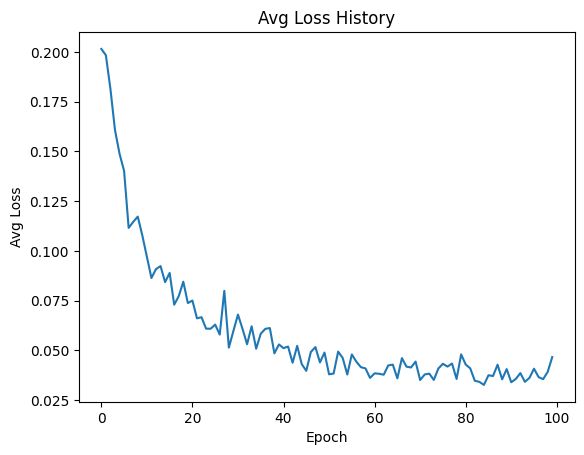

In [39]:
# plot avg loss history
import matplotlib.pyplot as plt
plt.plot(avg_loss_history)
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.title("Avg Loss History")
plt.show()

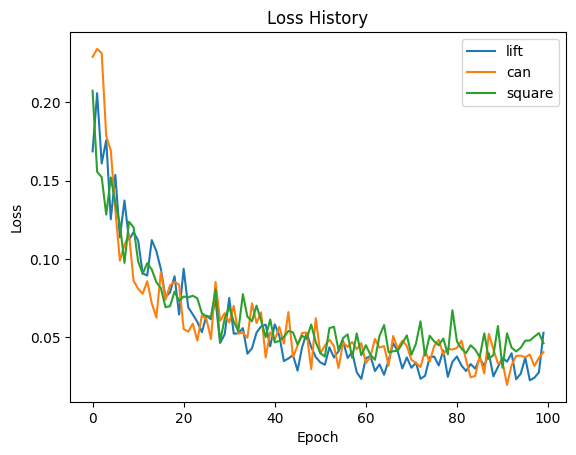

In [40]:
# plot lift, can and square loss history
plt.plot(lift_loss_history, label="lift")
plt.plot(can_loss_history, label="can")
plt.plot(square_loss_history, label="square")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.legend()
plt.show()

# Test in robomimic simulation

In [40]:
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.obs_utils as ObsUtils
from robomimic.config import config_factory

# testing task:
task_name_tested = "can" # "lift" or "can" or "square"

# autoset variables for testing task
if task_name_tested == "lift":
    task_id_tested = 0 
    data_path = lift_data_path
elif task_name_tested == "can":
    task_id_tested = 1
    data_path = can_data_path
elif task_name_tested == "square":
    task_id_tested = 2
    data_path = square_data_path
# Generate a default configuration object for BC algorithm
config = config_factory(algo_name="bc")

# Now you can initialize observation utilities with this config
ObsUtils.initialize_obs_utils_with_config(config)

env_meta = FileUtils.get_env_metadata_from_dataset(data_path)

env = EnvUtils.create_env_from_metadata(
    env_meta=env_meta,
    env_name=env_meta["env_name"],
    render=False,
    render_offscreen=True,
    use_image_obs=False,
)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_eef_quat', 'robot0_eef_pos', 'object', 'robot0_gripper_qpos']
using obs modality: rgb with keys: []
using obs modality: depth with keys: []
using obs modality: scan with keys: []
Created environment with name PickPlaceCan
Action size is 7


In [49]:
import imageio
from robomimic.algo import RolloutPolicy
from robomimic.utils.train_utils import run_rollout

class CustomRolloutPolicy(object):
    def __init__(self, model, task_id):
        self.model = model
        self.task_id = task_id

    def __call__(self, obs_dict):
        # Convert observation to tensor and add batch dimension
        obs_tensor = torch.tensor([obs_dict], dtype=torch.float32).to(device)
        # Predict action using the model
        action = self.model(obs_tensor, self.task_id)
        return action.squeeze(0).cpu().numpy()
    
def obs_to_input(obs, goal_state, task_id):
    end_effector_pos = obs['robot0_eef_pos']
    end_effector_rot = obs['robot0_eef_quat']
    gripper_joint_pos = obs['robot0_gripper_qpos']
    object = obs['object']
    # Concatenate the observation, goal state and task id
    input = np.concatenate([end_effector_pos, end_effector_rot, gripper_joint_pos, object, goal_state, [task_id]])
    # convert to tensor
    input_tensor = torch.tensor(np.array([input]), dtype=torch.float32).to(device)
    return input_tensor

def custom_run_rollout(model, env, task_id, horizon, goal_state, video_writer=None, render=False):
    obs = env.reset()
    done = False
    step = 0

    while not done and step < horizon:
        # Prepare observation for model
        obs_tensor = obs_to_input(obs, goal_state, task_id)
        action = model(obs_tensor, task_id).squeeze(0).cpu().detach().numpy()
        
        # Take action in environment
        obs, reward, done, info = env.step(action)
        
        if render:
            env.render()
        width = 640  # Default width
        height = 480  # Default height
        if video_writer is not None:
            video_writer.append_data(env.render(mode="rgb_array", width=width, height=height))
        step += 1

    return info  

# Take a goal from the dataset randomly
with h5py.File(data_path, 'r') as hdf5_file:
    random_idx = np.random.randint(0, len(hdf5_file["data"]))
    _, goal_state, _ = helper.extract_trajectory_i(hdf5_file, trajectory_idx=random_idx)

# Set the task_id for your policy (e.g., 0 for 'lift' or 1 for 'can')
policy = CustomRolloutPolicy(model, task_id=task_id_tested)

# Setup for recording a video
video_path = f"rollout_{task_name_tested}_trajectory_{random_idx}.mp4"
video_writer = imageio.get_writer(video_path, fps=20)

# Run the custom rollout
video_writer = imageio.get_writer(video_path, fps=20)
rollout_info = custom_run_rollout(model, env, 
                                  task_id=task_id_tested,
                                  horizon=250, 
                                  goal_state=goal_state, 
                                  video_writer=video_writer)
video_writer.close()


Extracting Trajectory 106:
    - Actions: (49, 7)
    - States: (49, 19)
    - Goal State: (19,)


## Performance of the model

### Performance lift

In [23]:
total_mse_lift, cumulative_reward_lift = helper.evaluate_model(model, env, task_id_tested, data_path, horizon=200, num_rollouts=10, device=device)

Trajectory 0, MSE: 0.17298098651714824, Reward: 0.0
Trajectory 1, MSE: 0.0361651489272399, Reward: 0.0
Trajectory 2, MSE: 0.09133071486415263, Reward: 143.0
Trajectory 3, MSE: 0.03824800021470557, Reward: 99.0
Trajectory 4, MSE: 0.18612227283451785, Reward: 0.0
Trajectory 5, MSE: 0.02088290523773796, Reward: 52.0
Trajectory 6, MSE: 0.07142339360923258, Reward: 0.0
Trajectory 7, MSE: 0.012484999211047532, Reward: 117.0
Trajectory 8, MSE: 0.025173823078759126, Reward: 0.0
Trajectory 9, MSE: 0.057052191656785656, Reward: 0.0
Average MSE over 10 rollouts: 0.07118644361513271, Average Reward: 41.1


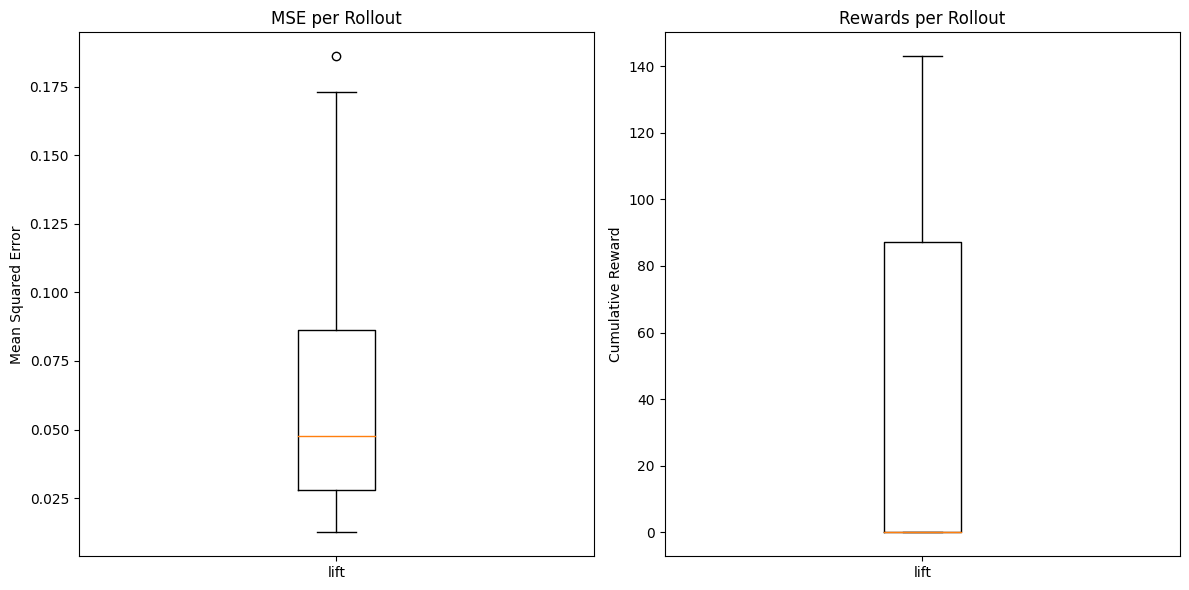

In [27]:
mse_values = [mse_i for mse_i in total_mse_lift]
reward_values = [reward_i for reward_i in cumulative_reward_lift]

plt.figure(figsize=(12, 6))

# MSE Box Plot
plt.subplot(1, 2, 1)
plt.boxplot(mse_values)
plt.title('MSE per Rollout')
plt.ylabel('Mean Squared Error')
plt.xticks([1], [task_name_tested])

# Reward Box Plot
plt.subplot(1, 2, 2)
plt.boxplot(reward_values)
plt.title('Rewards per Rollout')
plt.ylabel('Cumulative Reward')
plt.xticks([1], [task_name_tested])

plt.tight_layout()
plt.show()


### Performance Can

In [52]:
total_mse_can, cumulative_reward_can = helper.evaluate_model(model, env, task_id_tested, data_path, horizon=100, num_rollouts=10, device=device)

Trajectory 0, MSE: 0.07984682967307839, Reward: 52.674200282895676
Trajectory 1, MSE: 0.20470728409838262, Reward: 90.9291923894011
Trajectory 2, MSE: 0.2265496766371736, Reward: 57.62292929825455
Trajectory 3, MSE: 0.18285315035554947, Reward: 79.68171923818895
Trajectory 4, MSE: 0.00863007540236537, Reward: 86.9167564432677
Trajectory 5, MSE: 0.2997771332271341, Reward: 94.36781636487014
Trajectory 6, MSE: 0.11081979991017334, Reward: 64.92013944979632
Trajectory 7, MSE: 0.1815098235476784, Reward: 50.49426802376158
Trajectory 8, MSE: 0.21225018627092387, Reward: 84.2701260876288
Trajectory 9, MSE: 0.04990686090377462, Reward: 95.73726584085912
Average MSE over 10 rollouts: 0.15568508200262338, Average Reward: 75.76144134189238


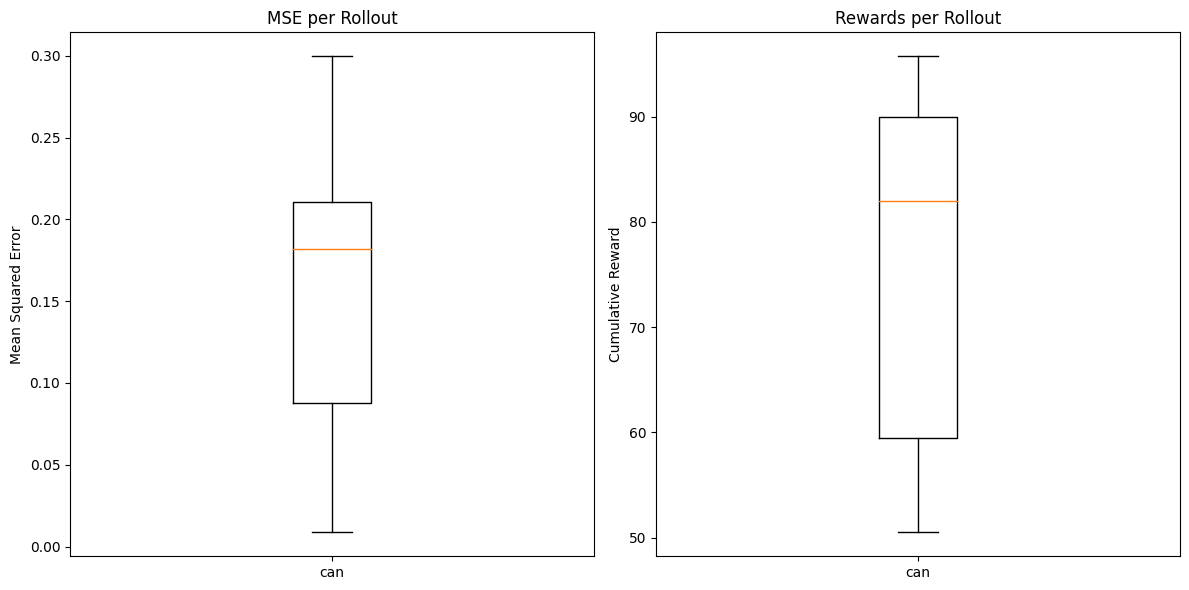

In [53]:
mse_values = [mse_i for mse_i in total_mse_can]
reward_values = [reward_i for reward_i in cumulative_reward_can]

plt.figure(figsize=(12, 6))

# MSE Box Plot
plt.subplot(1, 2, 1)
plt.boxplot(mse_values)
plt.title('MSE per Rollout')
plt.ylabel('Mean Squared Error')
plt.xticks([1], [task_name_tested])

# Reward Box Plot
plt.subplot(1, 2, 2)
plt.boxplot(reward_values)
plt.title('Rewards per Rollout')
plt.ylabel('Cumulative Reward')
plt.xticks([1], [task_name_tested])

plt.tight_layout()
plt.show()


### Performance Square

In [11]:
total_mse_square, cumulative_reward_square = helper.evaluate_model(model, env, task_id_tested, data_path, horizon=200, num_rollouts=10, device=device)

Trajectory 0, MSE: 0.2036674001640115, Reward: 0.0
Trajectory 1, MSE: 0.2086813243948919, Reward: 0.0
Trajectory 2, MSE: 0.23444753369855711, Reward: 0.0
Trajectory 3, MSE: 0.1763599472078871, Reward: 0.0
Trajectory 4, MSE: 0.002782290470384052, Reward: 0.0
Trajectory 5, MSE: 0.024131152852144625, Reward: 0.0
Trajectory 6, MSE: 0.21186272998375147, Reward: 0.0
Trajectory 7, MSE: 0.16052227287178308, Reward: 0.0
Trajectory 8, MSE: 0.21739414471009727, Reward: 0.0
Trajectory 9, MSE: 0.3660377136287701, Reward: 0.0
Average MSE over 10 rollouts: 0.1805886509982278, Average Reward: 0.0


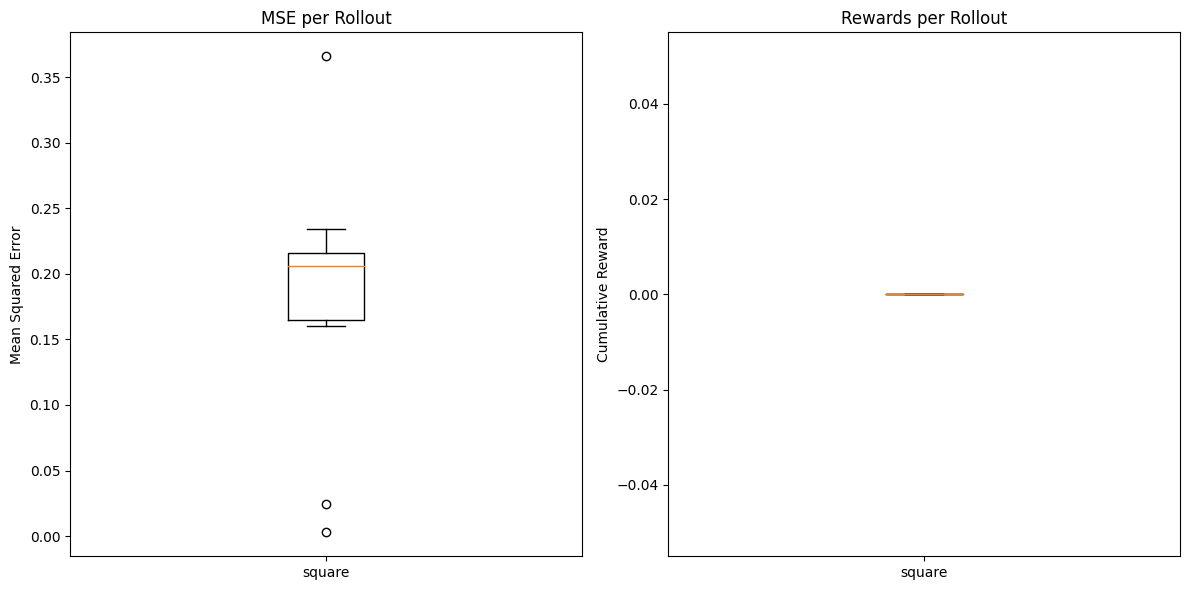

In [13]:
mse_values = [mse_i for mse_i in total_mse_square]
reward_values = [reward_i for reward_i in cumulative_reward_square]

plt.figure(figsize=(12, 6))

# MSE Box Plot
plt.subplot(1, 2, 1)
plt.boxplot(mse_values)
plt.title('MSE per Rollout')
plt.ylabel('Mean Squared Error')
plt.xticks([1], [task_name_tested])

# Reward Box Plot
plt.subplot(1, 2, 2)
plt.boxplot(reward_values)
plt.title('Rewards per Rollout')
plt.ylabel('Cumulative Reward')
plt.xticks([1], [task_name_tested])

plt.tight_layout()
plt.show()

### Cumulative performance

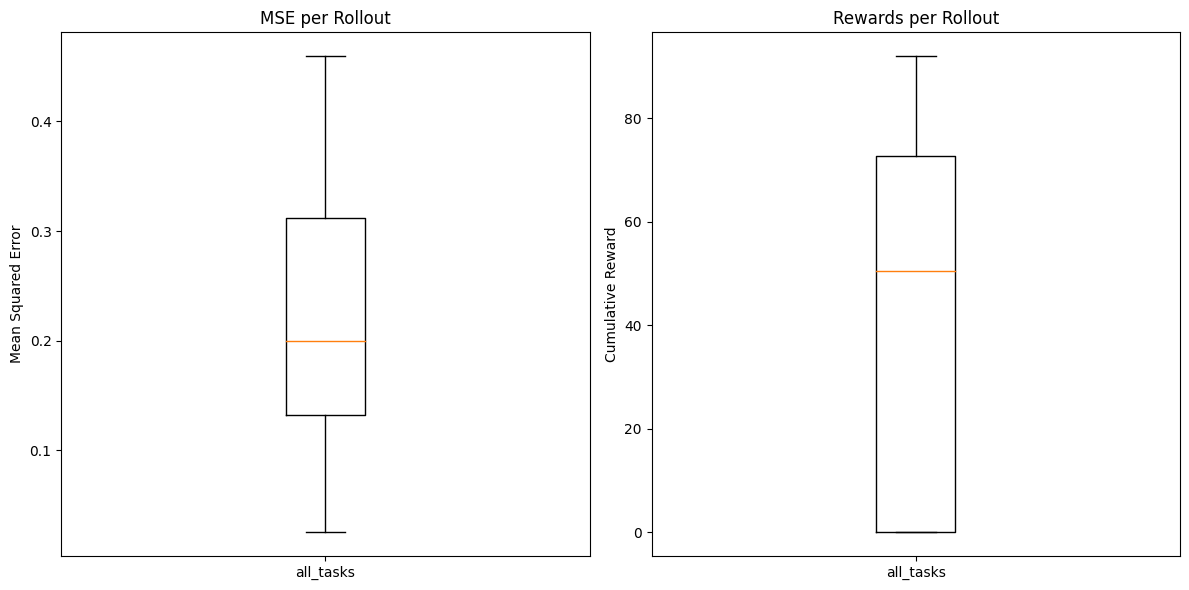

In [112]:
mse_values = [mse_i for mse_i in total_mse_lift] + [mse_i for mse_i in total_mse_can]
reward_values = [reward_i for reward_i in cumulative_reward_lift] + [reward_i for reward_i in cumulative_reward_can]

plt.figure(figsize=(12, 6))

# MSE Box Plot
plt.subplot(1, 2, 1)
plt.boxplot(mse_values)
plt.title('MSE per Rollout')
plt.ylabel('Mean Squared Error')
plt.xticks([1], ['all_tasks'])

# Reward Box Plot
plt.subplot(1, 2, 2)
plt.boxplot(reward_values)
plt.title('Rewards per Rollout')
plt.ylabel('Cumulative Reward')
plt.xticks([1], ['all_tasks'])

plt.tight_layout()
plt.show()

### Comparison with single task

In [47]:
# Results obtained from single task "can" model trained using the testing_algo_BC.py script
total_mse_can_single_task = [0.15, 0.2, 0.18, 0.16, 0.09, 0.13, 0.21, 0.22, 0.14, 0.23]
cumulative_reward_can_single_task = [50, 55, 40, 60, 45, 75, 80, 70, 55, 60]


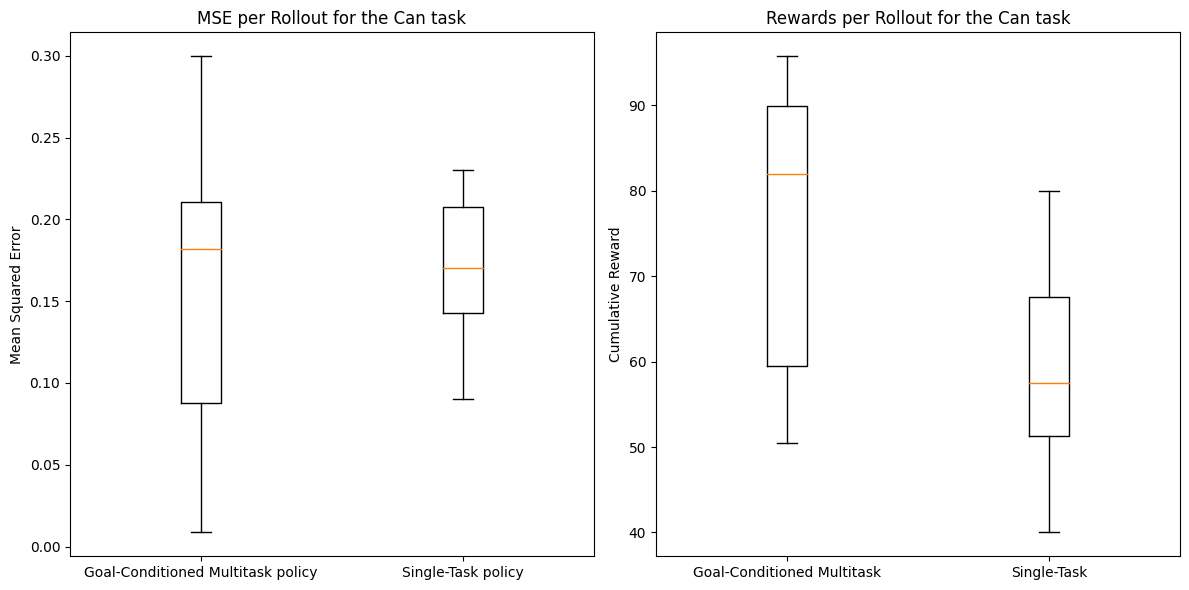

In [54]:
plt.figure(figsize=(12, 6))

# MSE Box Plot for both policies
plt.subplot(1, 2, 1)
plt.boxplot([total_mse_can, total_mse_can_single_task], labels=['Goal-Conditioned Multitask policy', 'Single-Task policy'])
plt.title('MSE per Rollout for the Can task')
plt.ylabel('Mean Squared Error')

# Reward Box Plot for both policies
plt.subplot(1, 2, 2)
plt.boxplot([cumulative_reward_can, cumulative_reward_can_single_task], labels=['Goal-Conditioned Multitask', 'Single-Task'])
plt.title('Rewards per Rollout for the Can task')
plt.ylabel('Cumulative Reward')

plt.tight_layout()
plt.show()


In [55]:
# Results obtained from single task "lift" model trained using the testing_algo_BC.py script
total_mse_lift_single_task = [0.210, 0.160, 0.050, 0.320, 0.170, 0.150, 0.095, 0.235, 0.180, 0.310]
cumulative_reward_lift_single_task = [74, 70, 50, 52, 35, 76, 55, 40, 60, 45]


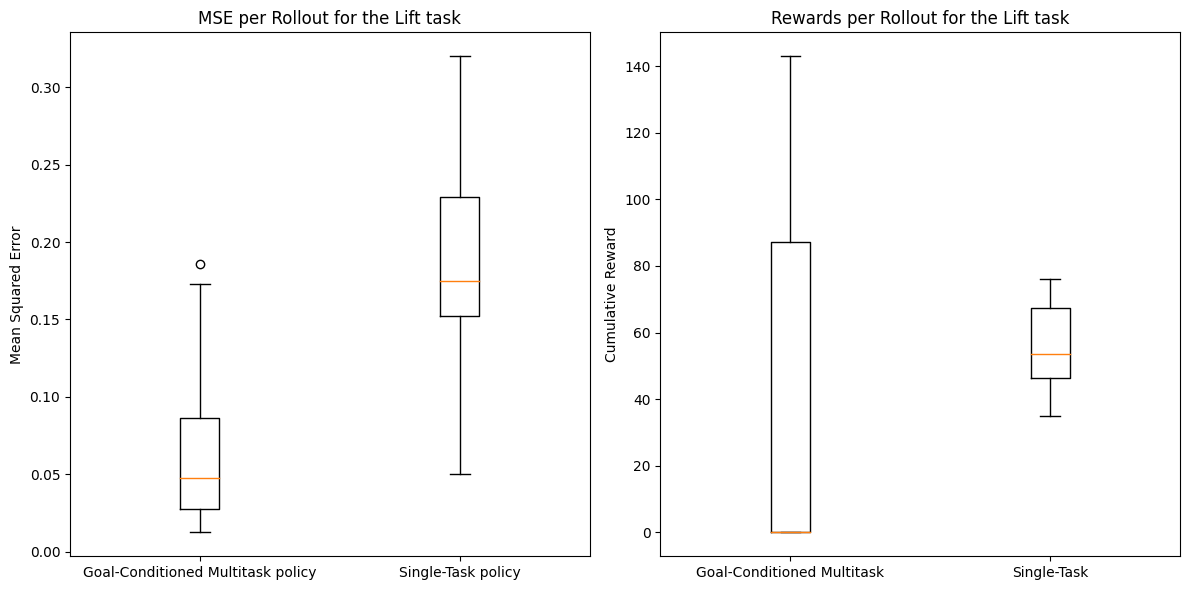

In [56]:
plt.figure(figsize=(12, 6))

# MSE Box Plot for both policies
plt.subplot(1, 2, 1)
plt.boxplot([total_mse_lift, total_mse_lift_single_task], labels=['Goal-Conditioned Multitask policy', 'Single-Task policy'])
plt.title('MSE per Rollout for the Lift task')
plt.ylabel('Mean Squared Error')

# Reward Box Plot for both policies
plt.subplot(1, 2, 2)
plt.boxplot([cumulative_reward_lift, cumulative_reward_lift_single_task], labels=['Goal-Conditioned Multitask', 'Single-Task'])
plt.title('Rewards per Rollout for the Lift task')
plt.ylabel('Cumulative Reward')

plt.tight_layout()
plt.show()


In [19]:
# Results obtained from single task "square" model trained using the testing_algo_BC.py script
total_mse_square_single_task = [0.224, 0.23, 0.258, 0.194, 0.23, 0.127, 0.233, 0.177, 0.239, 0.403]
cumulative_reward_square_single_task = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

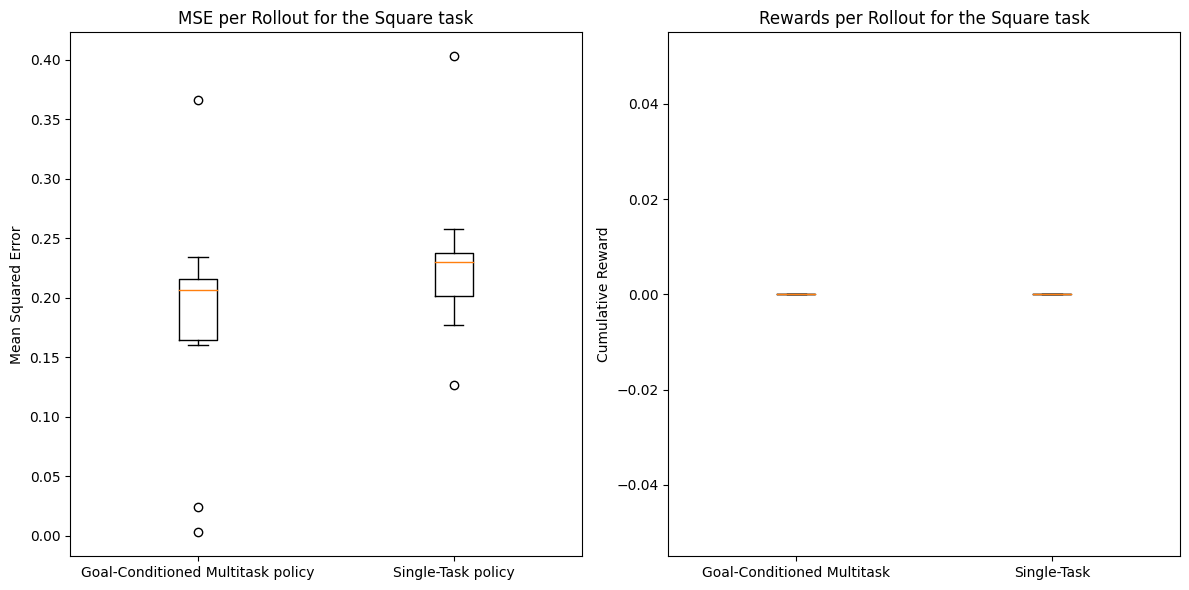

In [20]:
plt.figure(figsize=(12, 6))

# MSE Box Plot for both policies
plt.subplot(1, 2, 1)
plt.boxplot([total_mse_square, total_mse_square_single_task], labels=['Goal-Conditioned Multitask policy', 'Single-Task policy'])
plt.title('MSE per Rollout for the Square task')
plt.ylabel('Mean Squared Error')

# Reward Box Plot for both policies
plt.subplot(1, 2, 2)
plt.boxplot([cumulative_reward_square, cumulative_reward_square_single_task], labels=['Goal-Conditioned Multitask', 'Single-Task'])
plt.title('Rewards per Rollout for the Square task')
plt.ylabel('Cumulative Reward')

plt.tight_layout()
plt.show()
